# Racetrack
A simple extension of our last exploration into [gridworld](https://github.com/laxatives/rl/blob/master/gridworld_mdp.ipynb).

Here we extend exercise 5.12 in [Sutton & Barto](http://incompleteideas.net/book/the-book-2nd.html), shown below, to consider learning a driver agent while minimizing the cost of development, by utilizing off-policy learning to train experimental agents using only the limited data available from relatively proven, experienced drivers. We also choose to remove some of the velocity constraints imposed in the description below.

Our agent should learn the mechanics of maintaining a *racing line*, starting turns wide before committing to an apex to maximize speed out of the turn and minimize the total time spent navigating our "gridworld".

<img src="images/racetrack.png" width="85%" />
<img src="images/racetrack2.png" width="85%" />

In [1]:
from __future__ import print_function
from IPython.display import display
from pandas.plotting import register_matplotlib_converters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


pd.options.display.max_columns = None
register_matplotlib_converters()

%matplotlib inline

## The Action-Space
Driver can accelerate, coast, or decelerate in both X-Y axes.

In [2]:
from enum import Enum


MAX_VELOCITY = 5


class ActionX(Enum):
    """+X is East"""
    ACCEL = 'AX', 0, lambda x,y: (min(x + 1, MAX_VELOCITY), y), (1, 0)
    STEADY = 'SX', 1, lambda x,y: (x, y), (0, 0)
    DECEL = 'DX', 2, lambda x,y: (max(x - 1, -MAX_VELOCITY), y), (-1, 0)
    def __init__(self, display_name, index, transition, unit_vector):
        self.display_name = display_name
        self.index = index
        self.transition = transition  # matplotlib coordinates
        self.unit_vector = unit_vector  # matplotlib coordinates
        
    def __str__(self):
        return self.display_name
    
    
class ActionY(Enum):
    """+Y is North"""
    ACCEL = 'AY', 0, lambda x,y: (x, min(y + 1, MAX_VELOCITY)), (0, 1)
    STEADY = 'SY', 1, lambda x,y: (x, y), (0, 0)
    DECEL = 'DY', 2, lambda x,y: (x, max(y - 1, -MAX_VELOCITY)), (0, -1)
    def __init__(self, display_name, index, transition, unit_vector):
        self.display_name = display_name
        self.index = index
        self.transition = transition  # matplotlib coordinates
        self.unit_vector = unit_vector  # matplotlib coordinates
        
    def __str__(self):
        return self.display_name    

## The Grid

In [3]:
from itertools import product


class Track(object):
    def __init__(self, coords):
        # Everything is in matplotlib coordinates now (origin is bottom-left)
        # Let's never think about row-major ever again and pretend it never happened in the first-place
        self.coords = np.rot90(coords, 3)
        
        # Assumes start from bottom row
        self.starts = list(product([x for x, val in enumerate(coords[-1]) if val > 0], [0]))
        
        # Assumes right handed turn ending in North East corner
        end_y = set([i for i, val in enumerate(self.coords[-1]) if val > 0])
        self.is_end = lambda x,y: y in end_y and x >= coords.shape[1] - 1

In [4]:
track_a_coords = np.array([
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
])

TRACK_A = Track(track_a_coords)

In [5]:
track_b_coords = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],     
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
])

TRACK_B = Track(track_b_coords)

In [6]:
import matplotlib.lines as mlines
from itertools import product


def fill_square(x, y, ax, color, alpha=1.0):    
    square_x = [x, x, x+1, x+1]
    square_y = [y, y+1, y+1, y]
    ax.fill(square_x, square_y, color, alpha=alpha)


def plot_track(track, state=None, title='Race Track', padding=1, offset=0):    
    fig, ax = plt.subplots(figsize=(5, 4))    
    if title:
        ax.set_title(title)
    ax.set_xlim(-padding + offset, track.coords.shape[0] + padding + offset)
    ax.set_ylim(-padding + offset, track.coords.shape[1] + padding + offset)

    for x_ind, y_ind in product(range(-padding, track.coords.shape[0] + padding), 
                                range(-padding, track.coords.shape[1] + padding)):
        x, y = x_ind + offset, y_ind + offset
        if (0 <= x_ind < track.coords.shape[0] and 
                0 <= y_ind < track.coords.shape[1] and 
                track.coords[(x_ind, y_ind)] > 0):
            ax.add_line(mlines.Line2D([x,x+1], [y,y], color='k', linewidth=0.5))
            ax.add_line(mlines.Line2D([x,x], [y,y+1], color='k', linewidth=0.5))
            ax.add_line(mlines.Line2D([x+1,x+1], [y,y+1], color='k', linewidth=0.5))
            ax.add_line(mlines.Line2D([x,x+1], [y+1,y+1], color='k', linewidth=0.5))        
            
        if track.is_end(x_ind, y_ind):
            fill_square(x, y, ax, 'g', alpha=0.5)            
            
    for x_ind, y_ind in track.starts:
        x, y = x_ind + offset, y_ind + offset
        fill_square(x, y, ax, 'r', alpha=0.5)
        
    if state:
        x, y = state.position
        x += offset
        y += offset
        fill_square(x, y, ax, 'b', alpha=0.5)
        dx, dy = state.velocity
        ax.arrow(x + 0.5, y + 0.5, dx, dy, head_width=0.5)
        
    return fig, ax

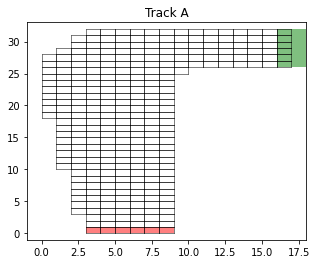

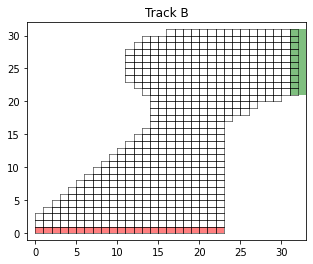

In [7]:
_ = plot_track(TRACK_A, title='Track A')
_ = plot_track(TRACK_B, title='Track B')
# TODO: chicane, import Circuit de Monaco

## The Environment

In [8]:
class DriverState(object):
    def __init__(self, position, velocity=(0, 0), terminal=False):
        self.position = position
        self.velocity = velocity
        self.terminal = terminal
        
    def __str__(self):
        s = f'x=({self.position[0]},{self.position[1]}),v=({self.velocity[0]},{self.velocity[1]})'
        if self.terminal:
            s += ',TERMINAL'
        return s
    

class Drive(object):
    def __init__(self, track, slippage=0):
        self.track = track
        self.state = DriverState(random.choice(track.starts))
        self.slippage = slippage
        
    def set_state(self, state):
        self.state = state

    def _transition_state(self, ax, ay):
        """Try to apply the ACTION and check whether it is valid."""
        vx, vy = self.state.velocity
        new_vx, new_vy = ay.transition(*ax.transition(vx, vy))
        
        x, y = self.state.position
        new_x, new_y = x + new_vx, y + new_vy
        
        # Tire slippage in X
        if random.random() < self.slippage:
            new_x = x
            
        # Tire slippage in Y
        if random.random() < self.slippage:
            new_y = y
        
        terminal = False
        if self.track.is_end(new_x, new_y):
            # Terminal state, episode ends
            terminal = True
        elif (new_x < 0 or new_x >= self.track.coords.shape[0] or 
              new_y < 0 or new_y >= self.track.coords.shape[1] or 
              self.track.coords[(new_x, new_y)] < 1):
            # CRASH
            return None
        return DriverState((new_x, new_y), (new_vx, new_vy), terminal=terminal)
    
    def transition(self, ax, ay):
        """Apply the given ACTION to the current state and return the new state and reward."""
        reward = -1
        new_state = self._transition_state(ax, ay)

        if new_state is None:
            # CRASH
            new_state = DriverState(random.choice(self.track.starts))
        elif new_state.terminal:
            # End of episode
            reward = 1           

        self.state = new_state
        return self.state, reward   
    
    def plot(self):
        plot_track(self.track, self.state)

## The Agent

In [9]:
class Driver(object):
    """Learn the Optimal Policy beginning with a random policy and no priors."""    
    def __init__(self, track, name='Learned', epsilon=0):
        self.action_values = np.zeros((track.coords.shape[0],  # state: x
                                       track.coords.shape[1],  # state: y
                                       2 * MAX_VELOCITY + 1,   # state: vx
                                       2 * MAX_VELOCITY + 1,   # state: vy
                                       len(ActionX) * len(ActionY)))
        self._policy = np.random.randint(0, 9, 
                                         (track.coords.shape[0],
                                          track.coords.shape[1],
                                          2 * MAX_VELOCITY + 1,
                                          2 * MAX_VELOCITY + 1))
        self.track = track        
        self.name = name
        self.epsilon = epsilon
        
    @staticmethod
    def itoa(i):
        """Int to Action"""
        if i < 0 or i > 8:
            raise RuntimeError(i)          
            
        ax = ActionX.STEADY
        vx = i % 3
        if vx == 0:
            ax = ActionX.ACCEL
        elif vx == 2:
            ax = ActionX.DECEL
            
        ay = ActionY.STEADY
        vy = i // 3
        if vy == 0:
            ay = ActionY.ACCEL
        elif vy == 2:
            ay = ActionY.DECEL
            
        return ax, ay
        
        
    def policy(self, state, explore=True):
        if explore and random.random() < self.epsilon:
            i = np.random.randint(0, 9)
        else:
            i = self._policy[state]
        return i
    
    def policy_improvement(self):
        """Update our policy based on our latest action_values"""
        policy_stable = True
        for s, old_i in np.ndenumerate(self._policy):
            new_i = np.argmax(self.action_values[s])
            if new_i != old_i:
                policy_stable = False
                self._policy[s] = new_i
            
        return policy_stable
    
    def plot_action_values(self, title=None, padding=1):
        if title == None:
            title = f'{self.name}: Mean Action Values'
        fig, ax = plot_track(self.track, title=title, padding=padding, offset=0.5)
        mean_action_values = np.zeros((self.action_values.shape[0] + 2*padding, 
                                       self.action_values.shape[1] + 2*padding))
        for x, y in product(range(self.action_values.shape[0]), range(self.action_values.shape[1])):
            # 0: vx, 1: vy, 2: a
            max_action_values = np.max(self.action_values[(x, y)], axis=2)
            mean_action_values[(x + padding, y + padding)] = np.mean(max_action_values)
        im = ax.imshow(mean_action_values.T, cmap='seismic', alpha=0.9)
        fig.colorbar(im, ax=ax)
        
    # TODO: plot policy


## The Algorithm: Monte Carlo
Unlike Value Iteration and Linear Programming, Monte Carlo allows us to focus on samples that are relevant. We target episodes beginning from the starting the line and can avoid training in the many invalid states outside of our track as well as unusual states, such as driving in reverse near the finish line.

In [10]:
# TODO: parallellize
def mc_control(drive, every_visit=False, gamma=0.9, epsilon=0.1,
               T=1000, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations // 10 if iterations > 10 else iterations + 1

    agent = Driver(drive.track, name='Max Verstappen', epsilon=epsilon)
    mean_return = np.zeros((drive.track.coords.shape[0],  # state: x
                            drive.track.coords.shape[1],  # state: y
                            2 * MAX_VELOCITY + 1,         # state: vx
                            2 * MAX_VELOCITY + 1,         # state: vy
                            len(ActionX) * len(ActionY)))
    return_count = np.zeros((drive.track.coords.shape[0],  # state: x
                             drive.track.coords.shape[1],  # state: y
                             2 * MAX_VELOCITY + 1,         # state: vx
                             2 * MAX_VELOCITY + 1,         # state: vy
                             len(ActionX) * len(ActionY)))    
    for i in range(1, iterations):
        if i % log_frequency == 0:
            print(f'\tIteration {i} of {iterations}...')
            agent.plot_action_values(title=f'MC Control: Iteration {i}')

        # Simulate episode from random (state, action)
        x0, y0 = random.choice(drive.track.starts)
        vx0, vy0 = (0, 0) 
        drive.set_state(DriverState(position=(x0, y0), velocity=(vx0, vy0)))                                                                             
        s0 = (x0, y0, vx0, vy0)  # position_x, position_y, velocity_x, velocity_y
        episode = [s0]  # s0, a0, s1, r1, a1, s2, r2, a2, s3...
                        
        a0 = np.random.randint(0, 8)
        steps = 0
        terminated = False
        while steps < T:
            state, r1 = drive.transition(*Driver.itoa(a0))
            s1 = (state.position[0], state.position[1], state.velocity[0], state.velocity[1])
            episode.extend([a0, s1, r1]) 
            if r1 >= 0:  # terminal state
                terminated = True
                break
            a0 = agent.policy(s1)
            steps += 1
            
        if not terminated:
            continue

        # Replay backwards from the end of the episode
        ret = 0
        j = steps - 1
        episode_returns = {}
        while j > 0:
            r1 = episode[3*j + 3]
            a0 = episode[3*j + 1]
            s0 = episode[3*j - 1]
            j -= 1

            ret = r1 + gamma * ret
            key = (s0[0], s0[1], s0[2], s0[3], a0)
            episode_returns[key] = ret
            if every_visit:
                mean_ret = mean_return[key]
                c = return_count[key]
                mean_return[key] = (mean_ret * c + ret) / (c + 1)
                return_count[key] = c + 1

        # Update action values q(s,a)
        for key, ret in episode_returns.items():
            if not every_visit:
                mean_ret = mean_return[key]
                c = return_count[key]
                mean_return[key] = (mean_ret * c + ret) / (c + 1)
                return_count[key] = c + 1
            agent.action_values[key] = mean_return[key]

        # Update policy
        agent.policy_improvement()
    return agent

### Learning the circuit

	Iteration 1000 of 10000...
	Iteration 2000 of 10000...
	Iteration 3000 of 10000...
	Iteration 4000 of 10000...
	Iteration 5000 of 10000...
	Iteration 7000 of 10000...
	Iteration 8000 of 10000...
	Iteration 9000 of 10000...


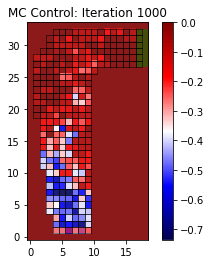

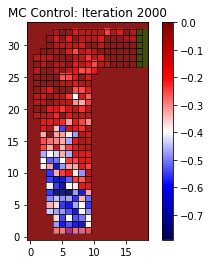

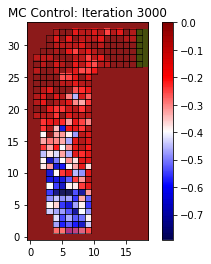

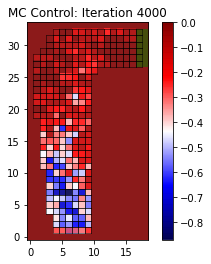

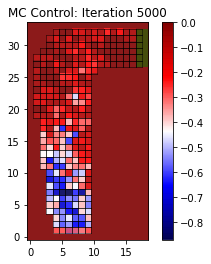

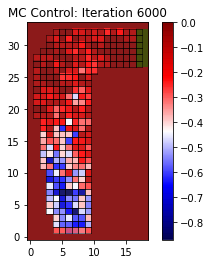

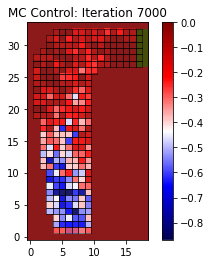

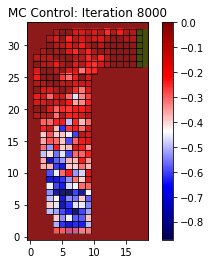

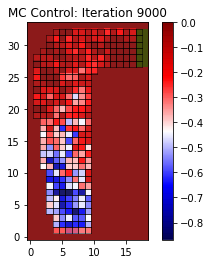

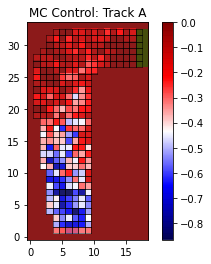

In [11]:
# Train Max Verstappen at Spa-Francorchamps
a = mc_control(Drive(TRACK_A), every_visit=True, T=int(1e5), iterations=int(1e4))
a.plot_action_values(title=f'MC Control: Track A')

### The Test

In [12]:
def test_drive(track, driver, max_steps=16):
    environment = Drive(track)
    
    i = 0
    r = -1
    state = environment.state
    while i < max_steps and r < 0:
        environment.plot() 
        
        s = (state.position[0], state.position[1], state.velocity[0], state.velocity[1])
        a = driver.policy(s, explore=False)
        state, r = environment.transition(*Driver.itoa(a))
        i += 1
        
    if r < 0:
        print("Max, that was embarassing.")

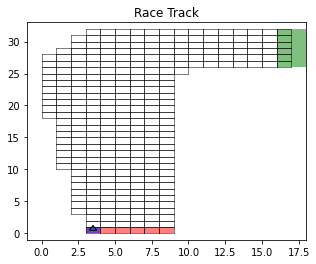

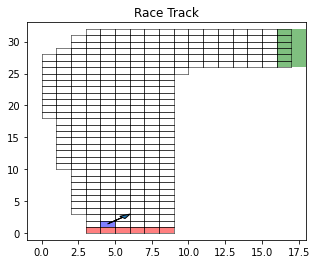

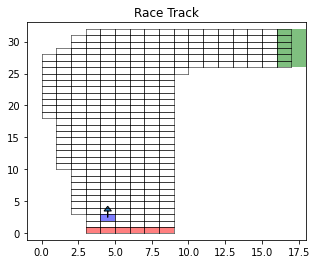

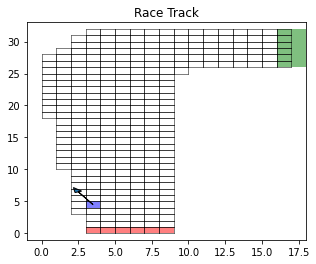

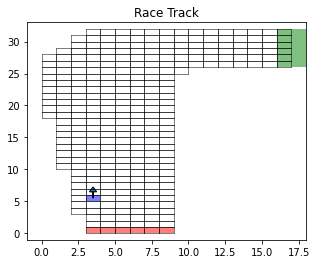

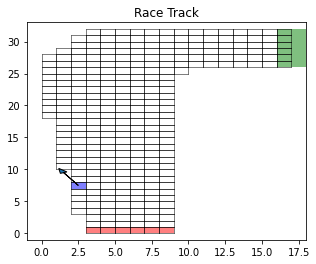

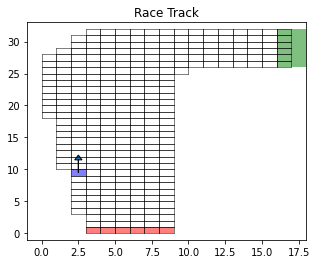

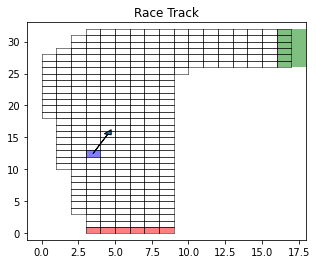

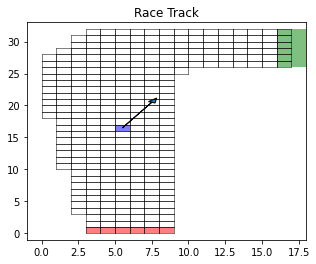

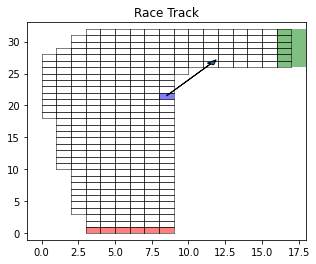

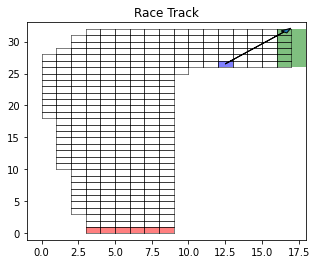

In [13]:
# Time Trial Max Verstappen
test_drive(TRACK_A, a)

## Track B: Monaco

	Iteration 1000 of 10000...
	Iteration 2000 of 10000...
	Iteration 3000 of 10000...
	Iteration 4000 of 10000...
	Iteration 5000 of 10000...
	Iteration 6000 of 10000...
	Iteration 7000 of 10000...
	Iteration 8000 of 10000...
	Iteration 9000 of 10000...


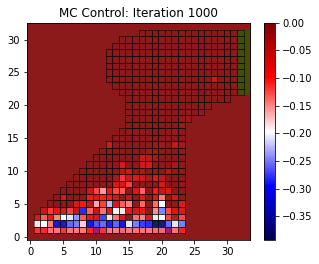

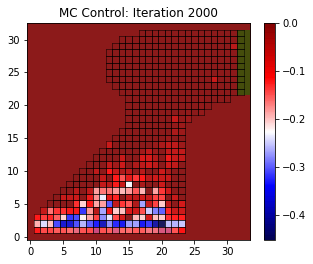

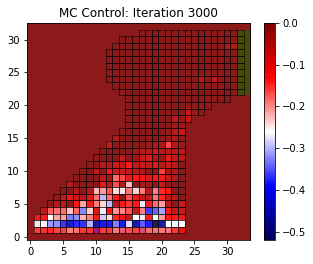

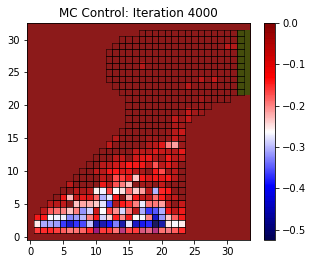

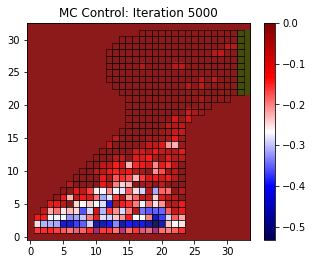

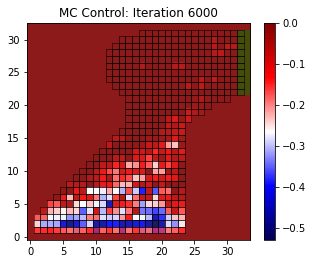

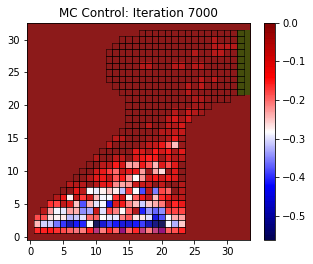

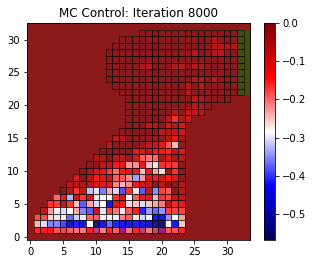

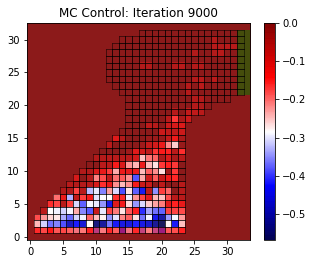

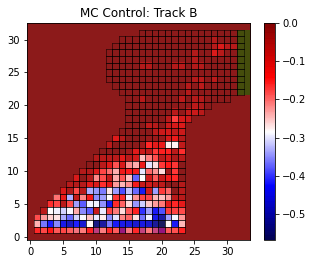

In [14]:
# Max putting in his time at Monte Carlo, Monaco
b = mc_control(Drive(TRACK_B), every_visit=True, T=int(1e5), iterations=int(1e4))
b.plot_action_values(title=f'MC Control: Track B')

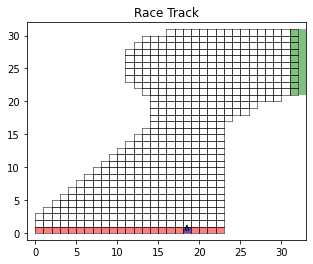

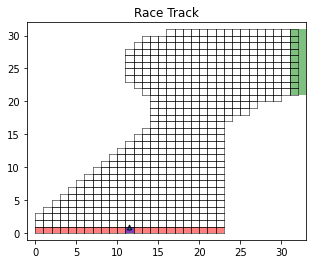

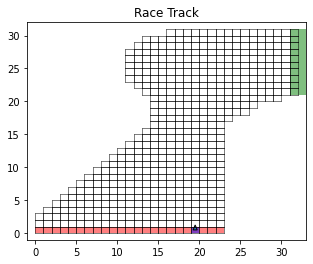

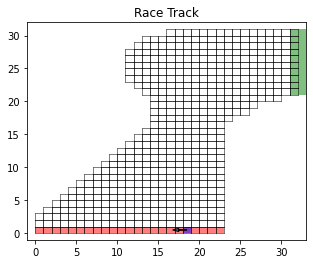

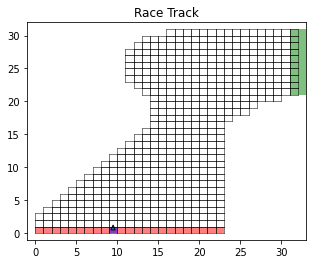

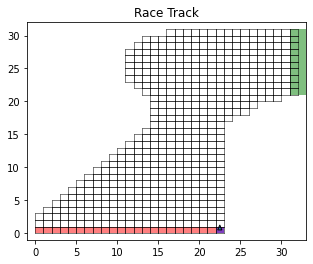

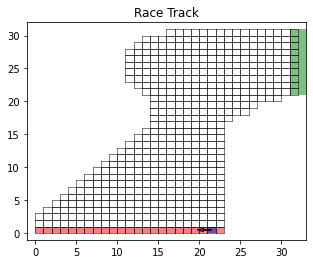

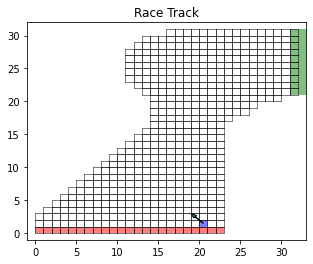

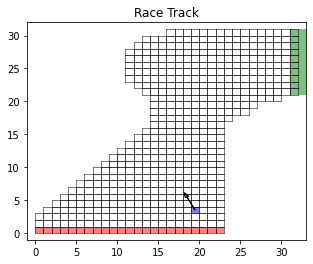

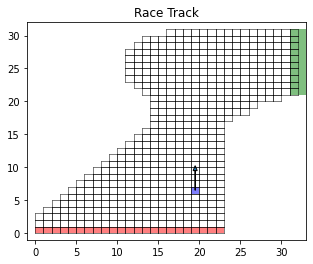

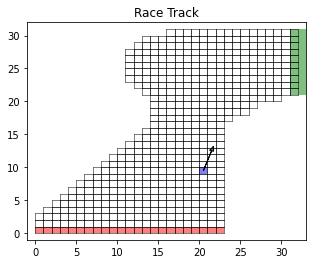

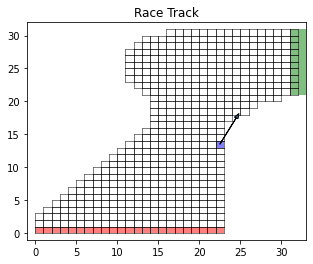

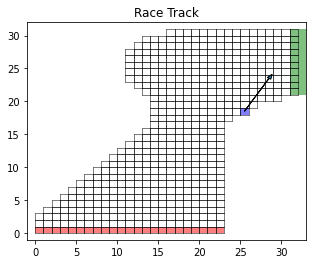

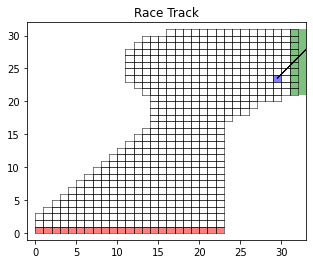

In [15]:
# Time Trial 
# Seems like its learning to cycle through bad start positions until it gets to a "good" start
test_drive(TRACK_B, b)

### Specification Gaming: Max Verstappen is a dirty cheater
The agent learns that it can repeatedly crash by moving backwards from the starting line until it gets to a "good" starting position where it has previously successfully completed the turn.

Let's try that again after forcing Max to pay for damages each time he crashes.

In [16]:
class DriveRevised(Drive):
    def transition(self, ax, ay):
        """Apply the given ACTION to the current state and return the new state and reward."""
        reward = -1
        new_state = self._transition_state(ax, ay)

        if new_state is None:
            # CRASH
            new_state = DriverState(random.choice(self.track.starts))
            reward = -1000  # The new penalty for crashing
        elif new_state.terminal:
            # End of episode
            reward = 1           

        self.state = new_state
        return self.state, reward   

	Iteration 1000 of 10000...
	Iteration 2000 of 10000...
	Iteration 3000 of 10000...
	Iteration 4000 of 10000...
	Iteration 5000 of 10000...
	Iteration 6000 of 10000...
	Iteration 7000 of 10000...
	Iteration 8000 of 10000...
	Iteration 9000 of 10000...


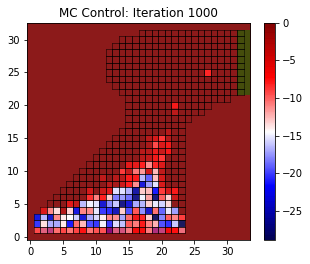

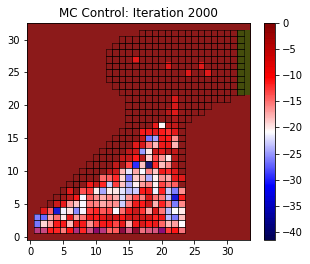

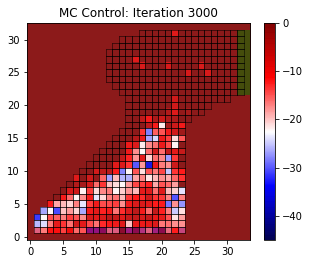

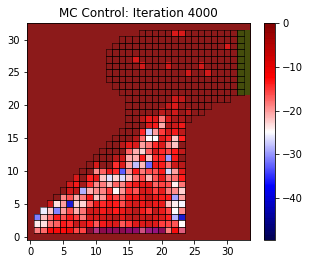

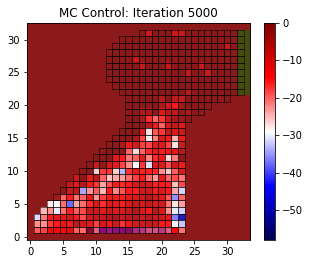

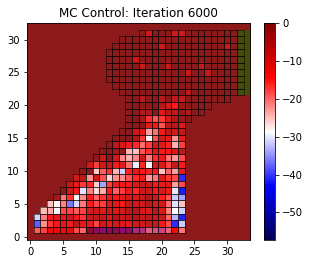

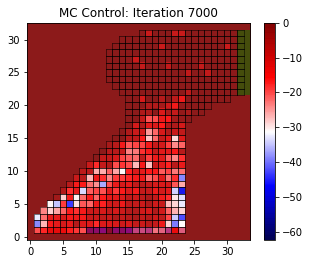

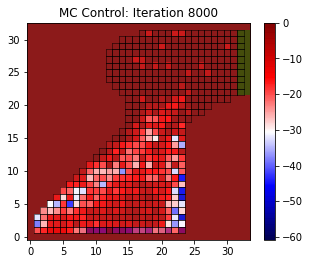

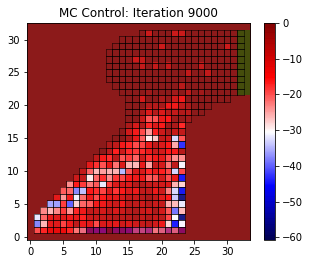

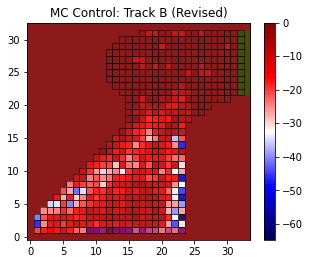

In [17]:
b_revised = mc_control(DriveRevised(TRACK_B), every_visit=True, T=int(1e5), iterations=int(1e4))
b_revised.plot_action_values(title=f'MC Control: Track B (Revised)')

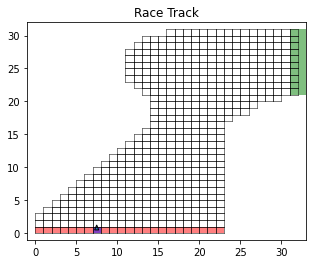

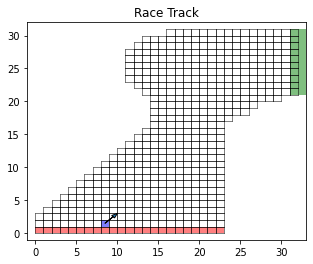

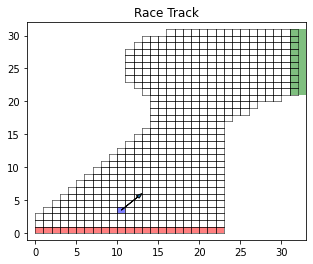

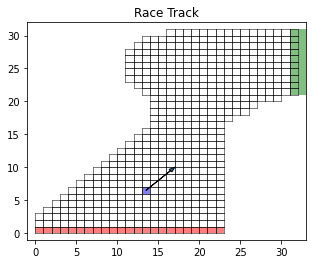

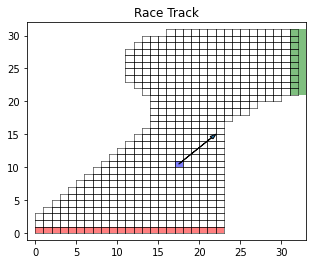

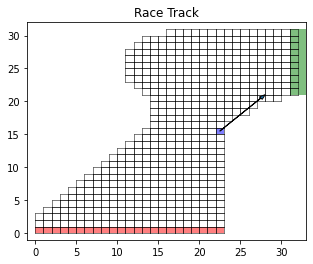

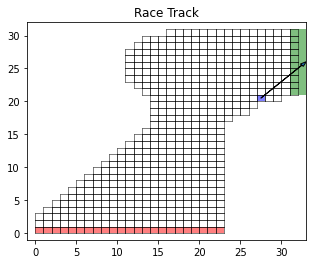

In [18]:
test_drive(TRACK_B, b_revised)

## Consider Slippage
Let's add the complexity of probabilistic state transitions by treating tire traction as non-deterministic. However our algorithm doesn't require a model for the environment and our approach is unchanged. Changes to our environment are fully captured in our episode generation process.

We expect Max to drive a bit more conservatively when losing control is a risk.

In [ ]:
a_slippage = mc_control(DriveRevised(TRACK_A, slippage=0.1), T=int(1e5), iterations=int(1e4))
a_slippage.plot_action_values(title=f'MC Control: Track A w/ Slippage')

In [ ]:
test_drive(TRACK_A, a_slippage)

In [ ]:
b_slippage = mc_control(DriveRevised(TRACK_B, slippage=0.1), T=int(1e5), iterations=int(1e4))
b_slippage.plot_action_values(title=f'MC Control: Track A w/ Slippage')

In [ ]:
test_drive(TRACK_B, b_slippage)

## Off-Policy MC
Let's have Max learn sitting passenger side for some hot laps with Richard Hamilton.

In [ ]:
# TODO